<h2 style='color:green' align='center'>Indian Entrepreneurs Image Classification<h2>

In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

<h3 style='color:blue'> Preprocessing: Detecting the face and eyes</h3>

#### Now how do you detect face and eyes?

In [2]:
img = cv2.imread('./test_images/ratan tata.jpg')
img.shape

(1000, 1000, 3)

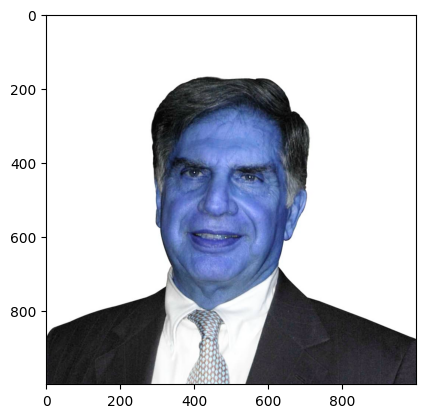

In [3]:
plt.imshow(img)  #here (1000,1000,3) == (height,width,rgb value of the image)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(1000, 1000)

In [5]:
gray

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [ 39,  43,  45, ...,  56,  58,  59],
       [ 45,  49,  52, ...,  58,  62,  64],
       [ 55,  59,  63, ...,  66,  71,  74]], dtype=uint8)

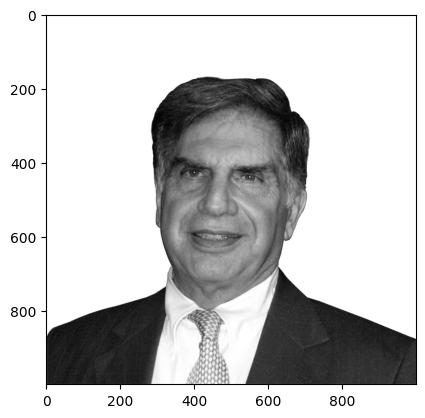

In [6]:
plt.imshow(gray, cmap='gray')

In [7]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces  

array([[272, 278, 414, 414]])

In [8]:
(x,y,w,h) = faces[0]
x,y,w,h

(272, 278, 414, 414)

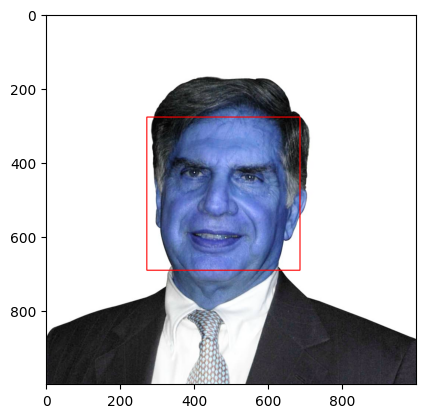

In [9]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

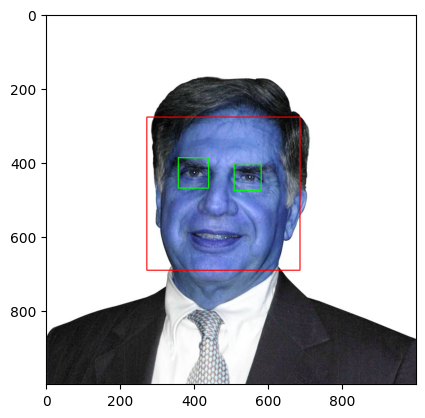

In [10]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

<h3 style='color:purple'>(2) Preprocessing: Crop the facial region of the image</h3>

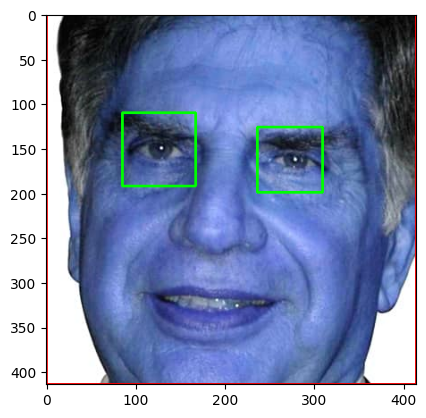

In [11]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [12]:
cropped_img = np.array(roi_color)
cropped_img.shape

(414, 414, 3)

<h3 style='color:purple'>(3) Preprocessing: Use wavelet transform as a feature for traning our model</h3>

#### In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc

### Wavelet transform

In [13]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

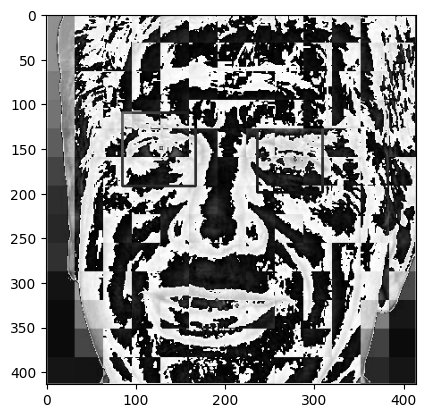

In [14]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

#### You can see above a wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

<h3 style='color:purple'>(3) Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region</h3>

####  Lets write a python function that can take input image and returns cropped image (if face and eyes >=2 are detected)

In [15]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    #print(img)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

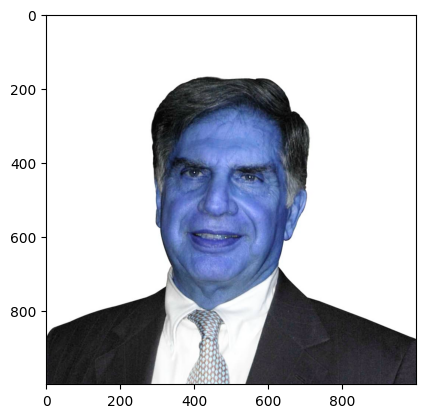

In [16]:
original_image = cv2.imread('./test_images/ratan tata.jpg')
plt.imshow(original_image)

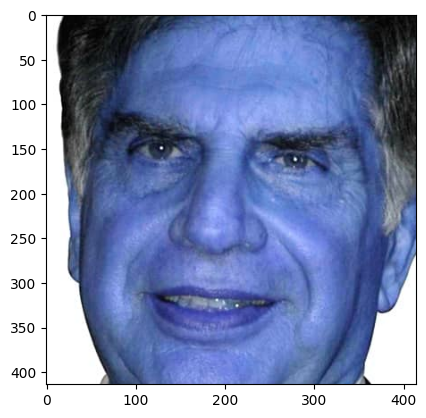

In [17]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/ratan tata.jpg')
plt.imshow(cropped_image)

**In below image face is not very clear and it doesn't have two eyes clearly visible**

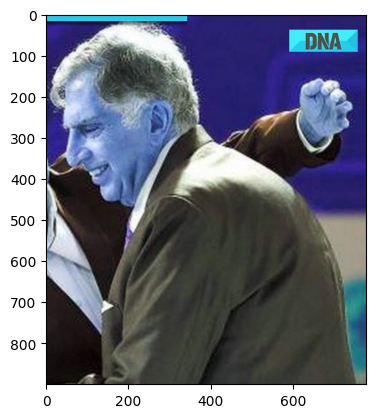

In [18]:
org_image_obstructed = cv2.imread('./test_images/ratan tata 2.jpg')
plt.imshow(org_image_obstructed)

In [19]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/ratan tata 2.jpg')
cropped_image_no_2_eyes

**Above cropped_image_no_2_eyes is None which means we should ignore this image and we will not use such image for model training**

In [30]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [31]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [32]:
img_dirs

['./dataset/azim-premji',
 './dataset/lakshmi_niwas_mittal',
 './dataset/mukesh_ambani',
 './dataset/nr_narayana_murthy',
 './dataset/ratan_tata',
 './dataset/ritesh_agarwal',
 './dataset/satya_nadella',
 './dataset/shantanu_narayen',
 './dataset/sundar_pichai']

**Go through all images in dataset folder and create cropped images for them. There will be cropped folder inside dataset folder after you run this code**

In [33]:
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [34]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        #print(entry)
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./dataset/cropped/azim-premji
Generating cropped images in folder:  ./dataset/cropped/lakshmi_niwas_mittal
Generating cropped images in folder:  ./dataset/cropped/mukesh_ambani
Generating cropped images in folder:  ./dataset/cropped/nr_narayana_murthy
Generating cropped images in folder:  ./dataset/cropped/ratan_tata
Generating cropped images in folder:  ./dataset/cropped/ritesh_agarwal
Generating cropped images in folder:  ./dataset/cropped/satya_nadella
Generating cropped images in folder:  ./dataset/cropped/shantanu_narayen
Generating cropped images in folder:  ./dataset/cropped/sundar_pichai


### Now you should have cropped folder under datasets folder that contains cropped images

### Manually examine cropped folder and delete any unwanted images

In [35]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'azim-premji': ['./dataset/cropped/azim-premji\\zim-premji1.png',
  './dataset/cropped/azim-premji\\zim-premji10.png',
  './dataset/cropped/azim-premji\\zim-premji11.png',
  './dataset/cropped/azim-premji\\zim-premji12.png',
  './dataset/cropped/azim-premji\\zim-premji13.png',
  './dataset/cropped/azim-premji\\zim-premji14.png',
  './dataset/cropped/azim-premji\\zim-premji15.png',
  './dataset/cropped/azim-premji\\zim-premji16.png',
  './dataset/cropped/azim-premji\\zim-premji18.png',
  './dataset/cropped/azim-premji\\zim-premji19.png',
  './dataset/cropped/azim-premji\\zim-premji2.png',
  './dataset/cropped/azim-premji\\zim-premji21.png',
  './dataset/cropped/azim-premji\\zim-premji23.png',
  './dataset/cropped/azim-premji\\zim-premji24.png',
  './dataset/cropped/azim-premji\\zim-premji25.png',
  './dataset/cropped/azim-premji\\zim-premji26.png',
  './dataset/cropped/azim-premji\\zim-premji27.png',
  './dataset/cropped/azim-premji\\zim-premji28.png',
  './dataset/cropped/azim-premji\

In [36]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'azim-premji': 0,
 'lakshmi_niwas_mittal': 1,
 'mukesh_ambani': 2,
 'nr_narayana_murthy': 3,
 'ratan_tata': 4,
 'ritesh_agarwal': 5,
 'satya_nadella': 6,
 'shantanu_narayen': 7,
 'sundar_pichai': 8}

### Images in cropped folder can be used for model training. We will use these raw images along with wavelet transformed images to train our classifier. Let's prepare X and y now

In [37]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [38]:
len(X[0])

4096

In [39]:
32*32*3 + 32*32

4096

In [40]:
X[0]

array([[206],
       [203],
       [205],
       ...,
       [200],
       [215],
       [231]], dtype=uint8)

In [41]:
y[0]

0

In [42]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(367, 4096)

### Data cleaning process is done. Now we are ready to train our model

We will use SVM with rbf kernel tuned  with heuristic finetuning

In [43]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.75

In [45]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.82      0.69      0.75        13
           2       0.86      0.50      0.63        12
           3       1.00      0.20      0.33         5
           4       0.64      0.78      0.70         9
           5       0.71      0.94      0.81        16
           6       1.00      0.57      0.73         7
           7       0.67      1.00      0.80        14
           8       0.70      0.88      0.78         8

    accuracy                           0.75        92
   macro avg       0.82      0.70      0.71        92
weighted avg       0.79      0.75      0.74        92



### Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters

In [46]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [47]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [49]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.792727,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.505455,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.832727,{'logisticregression__C': 1}


In [50]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [51]:
best_estimators['svm'].score(X_test,y_test)

0.8260869565217391

In [52]:
best_estimators['random_forest'].score(X_test,y_test)

0.5217391304347826

In [53]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8260869565217391

In [54]:
best_clf = best_estimators['svm']

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 8,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 11,  0,  0,  0,  2,  0,  0,  0],
       [ 0,  1,  9,  0,  1,  0,  0,  1,  0],
       [ 1,  0,  0,  2,  0,  0,  0,  1,  1],
       [ 0,  2,  0,  0,  6,  1,  0,  0,  0],
       [ 0,  0,  1,  0,  0, 15,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  6,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 14,  0],
       [ 0,  0,  1,  0,  0,  2,  0,  0,  5]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

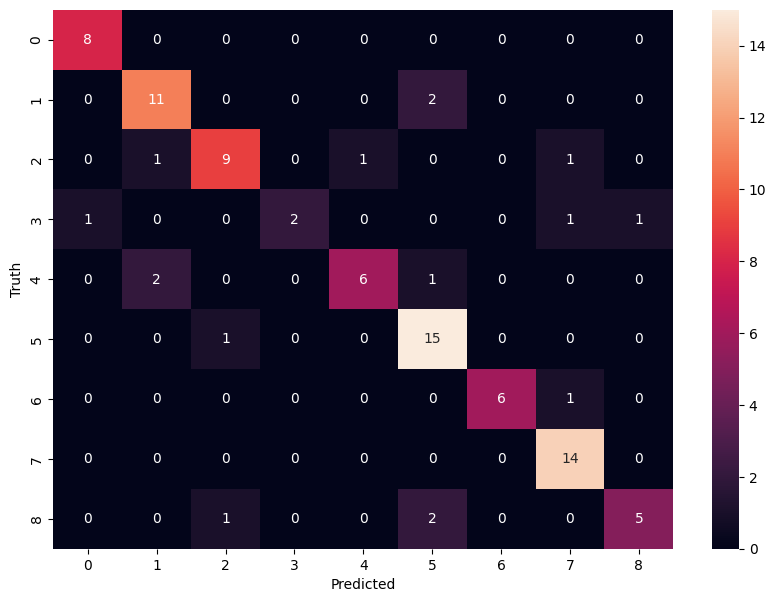

In [56]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [57]:
class_dict

{'azim-premji': 0,
 'lakshmi_niwas_mittal': 1,
 'mukesh_ambani': 2,
 'nr_narayana_murthy': 3,
 'ratan_tata': 4,
 'ritesh_agarwal': 5,
 'satya_nadella': 6,
 'shantanu_narayen': 7,
 'sundar_pichai': 8}

### Save the trained model

In [58]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

### Save class dictionary

In [59]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))